# Задание 1
Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories). Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

Данные:

active_users – информация о пользователях, которые посещали приложение во время эксперимента

groups – разбивка пользователей на контрольную (А) и тестовую (В) группы

purchases – данные о транзакциях (оплатах) пользователей приложения во время эксперимента

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm

In [2]:
active_users = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/B4QnY5D5EtKa-A')

In [3]:
active_users

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male
...,...,...,...,...
8336,2417,Sweden,ios,female
8337,3755,Russia,ios,male
8338,4594,Sweden,android,female
8339,7430,Sweden,ios,female


In [4]:
active_users.dtypes

user_id      int64
country     object
platform    object
sex         object
dtype: object

In [5]:
active_users.isnull().sum()

user_id     0
country     0
platform    0
sex         0
dtype: int64

In [6]:
groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/jP_BAw_oxS3law')

In [7]:
groups

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B
...,...,...
74571,1010,B
74572,7785,A
74573,1783,B
74574,1164,A


In [8]:
groups.dtypes

user_id     int64
group      object
dtype: object

In [9]:
groups.isnull().sum()

user_id    0
group      0
dtype: int64

In [10]:
purchases = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/AmucCdboEaowhA')

In [11]:
purchases

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0
...,...,...
536,5648,1908.0
537,2277,1912.0
538,5032,1911.0
539,908,1910.0


In [12]:
purchases.dtypes

user_id      int64
revenue    float64
dtype: object

In [13]:
purchases.isnull().sum()

user_id    0
revenue    0
dtype: int64

# Соединяем active_users и groups через innerjoin, т.к. нас интересуют пользователи, которые были активны и были разделены на a/b группы

In [14]:
df = active_users.merge(groups, how='inner', on='user_id') 

# Соединяем полученный датафрейм и purchases через leftjoin, т.к. нас интересуют все пользователи, которые были активны и разделены на группы

In [15]:
full_df = df.merge(purchases, how='left', on='user_id')

In [16]:
full_df

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,NaN
1,1735,Sweden,ios,male,B,NaN
2,7697,Russia,android,male,B,NaN
3,1421,Sweden,android,female,B,NaN
4,1704,Russia,ios,male,B,NaN
...,...,...,...,...,...,...
8336,2417,Sweden,ios,female,B,NaN
8337,3755,Russia,ios,male,A,590.0
8338,4594,Sweden,android,female,B,NaN
8339,7430,Sweden,ios,female,B,NaN


In [17]:
full_df.isnull().sum()

user_id        0
country        0
platform       0
sex            0
group          0
revenue     7949
dtype: int64

In [18]:
full_df = full_df.fillna(0) 

In [19]:
full_df.head()

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,0.0
1,1735,Sweden,ios,male,B,0.0
2,7697,Russia,android,male,B,0.0
3,1421,Sweden,android,female,B,0.0
4,1704,Russia,ios,male,B,0.0


# Интересующие метрики

ARPPU - средний доход на платящего пользователя (клиента)

CR - конверсия пользователя в клиента (в покупку)

ARPU - средний доход с привлечённого пользователя

In [ ]:
# Посмотрим на соотношение количество платящих пользователей

In [34]:
full_df.query('revenue > 0')\
        .groupby('group')\
        .user_id.agg(absolute = 'count', 
                     percent = lambda x: round(x.count() / full_df.query('revenue > 0').shape[0] * 100, 1))

,absolute,percent
group,,
A,78,19.9
B,314,80.1


In [20]:
arppu_A = full_df.query('group == "A"').revenue.sum() / full_df.query('group == "A" and revenue > 0').shape[0]
arppu_B = full_df.query('group == "B"').revenue.sum() / full_df.query('group == "B" and revenue > 0').shape[0]

print('ARPPU в контрольной группе {} \
       ARPPU в тестовой группе {}'.format(arppu_A.round(2), arppu_B.round(2)))
print('ARPPU изменился на {}%'.format(round(100*(arppu_B - arppu_A)/arppu_A,2)))

ARPPU в контрольной группе 943.56        ARPPU в тестовой группе 1267.88
ARPPU изменился на 34.37%


In [21]:
cr_A = full_df.query('group == "A" and revenue > 0').user_id.nunique() / full_df.query('group == "A"').user_id.nunique()
cr_B = full_df.query('group == "B" and revenue > 0').user_id.nunique() / full_df.query('group == "B"').user_id.nunique()

print('CR в контрольной группе {} \
       CR в тестовой группе {}'.format(cr_A, cr_B))
print('CR изменился на {}%'.format(round(100*(cr_B - cr_A)/cr_A,2)))

CR в контрольной группе 0.05071521456436931        CR в тестовой группе 0.046156107599588415
CR изменился на -8.99%


In [22]:
arpu_A = arppu_A * cr_A
arpu_B = arppu_B * cr_B

print('ARPU в контрольной группе {} \
       ARPU в тестовой группе {}'.format(arpu_A.round(2), arpu_B.round(2)))
print('ARPU изменился на {}%'.format(round(100*(arpu_B - arpu_A)/arpu_A,2)))

ARPU в контрольной группе 47.85        ARPU в тестовой группе 58.52
ARPU изменился на 22.29%


## ARPPU в тестовой группе выше, чем в контрольной, при этом показатель CR тестовой группе ниже, чем в контрольной. Несмотря на низкий показатель CR, ARPU  выше в тестовой группе, чем в контрольной. Необходимо рассмотреть, значимые ли эти изменения в разрезе влияющих на это метрик

Построим графики распределения выручки от пользователей контрольной и тестовой группы, совершивших платеж


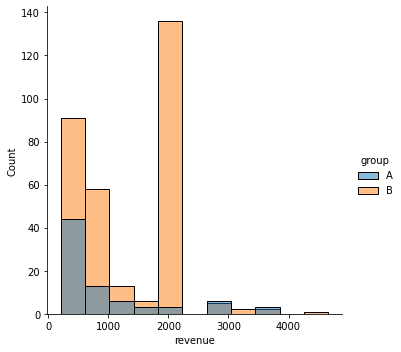

In [23]:
sns.displot(data=full_df.query('revenue > 0'), x='revenue', hue='group')

# Проверим распределение на нормальность

In [45]:
stats.shapiro(full_df.query('group == "A" and revenue > 0').revenue)

ShapiroResult(statistic=0.7358548641204834, pvalue=1.5417730980793465e-10)

In [46]:
stats.shapiro(full_df.query('group == "B" and revenue > 0').revenue)

ShapiroResult(statistic=0.8552882671356201, pvalue=1.665431681028873e-16)

# Распределение пользователей, совершивших покупку, не является нормальным, поэтому будем применять: Т-критерий Стьюдента, тест Манна-Уитни и бутстрап

# Сформулируем наши гипотизы:
# H0 Разницы между средними оплатами в контрольной и тестовой группе нет
# H1 Разница между средними оплатами в контрольной и тестовой группе есть


In [47]:
stats.ttest_ind(full_df.query('group == "A" and revenue > 0').revenue, 
                full_df.query('group == "B" and revenue > 0').revenue)

Ttest_indResult(statistic=-3.134033935298925, pvalue=0.0018546337642145053)

In [48]:
stats.mannwhitneyu(full_df.query('group == "A" and revenue > 0').revenue, 
                   full_df.query('group == "B" and revenue > 0').revenue)

MannwhitneyuResult(statistic=8961.0, pvalue=0.00023939080114586078)

# Мы получили p-значение меньше 0.05 в обоих тестах, а это значит, что мы отклоняем нашу нулевую гипотезу о том, что разницы между средними оплатами в контрольной и тестовой группе нет
# Оценим значимость этих различий с помощью бутстрап

In [49]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [50]:
revenue_control = full_df.query('group == "A" and revenue > 0').revenue
revenue_test = full_df.query('group == "B" and revenue > 0').revenue

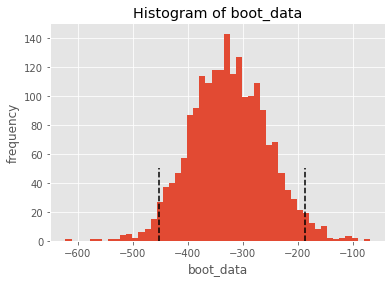

3.0582657342225812e-06

In [51]:
booted_data = get_bootstrap(revenue_control, revenue_test, boot_it=2000, statistic=np.mean)
booted_data['p_value']

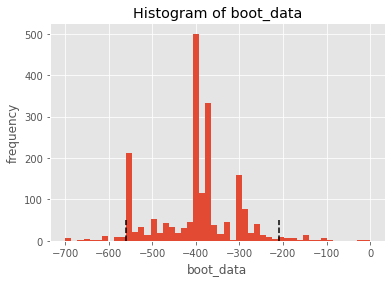

2.1210449145020907e-05

In [52]:
booted_data = get_bootstrap(revenue_control, revenue_test, boot_it=2000, statistic=np.median)
booted_data['p_value']

# Проверяем значимость различий ARPU

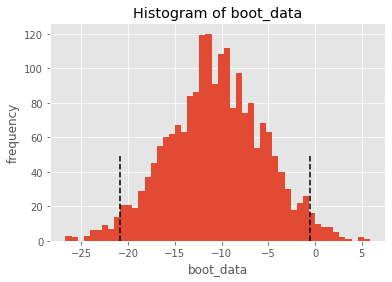

0.03886311728251038

In [53]:
res_ARPU = get_bootstrap(full_df.query('group == "A"').revenue, 
                         full_df.query('group == "B"').revenue, 
                         boot_it=2000, 
                         statistic=np.mean)
res_ARPU['p_value']

# Наше значение p_value < 0.05, что позволяет отвергнуть нулевую гипотезу, и сделать вывод, что ARPU в тестовой выборке больше, чем ARPU в контрольной.

# Проверяем значимость различий ARPPU

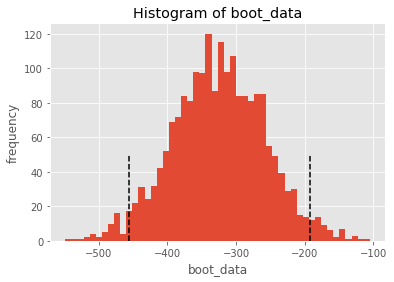

1.222828889049145e-06

In [54]:
res_ARPPU = get_bootstrap(full_df.query('group == "A" and revenue > 0').revenue,
                          full_df.query('group == "B" and revenue > 0').revenue, 
                          boot_it=2000, 
                          statistic=np.mean)
res_ARPPU["p_value"]

# Наше значение p_value < 0.05, что позволяет отвергнуть нулевую гипотезу, и сделать вывод, что ARPPU в тестовой выборке больше, чем ARPPU в контрольной.

### ВЫВОДЫ:
# По результатам 3х проверок с помощью тестов Т-критерий Стьюдента и Манна-Уитни и с помощью бутстрап, можно сделать вывод о том, что в тестовой группе с новой механикой, показатель средней выручки на 1 пользователя (ARPU), а также  показатель прибыли на 1 платящего пользователя (ARPPU) статистически значимые. Можем сделать вывод о том, что новую модель оплаты можно выкатывать на всех пользователей.

# Задание 2
Одной из основных задач аналитика является не только построение моделей, но и создание дашбордов, которые позволяют отслеживать изменения метрик и принимать на их основе оптимальные решения. Ваш руководитель хочет узнать, как обстоят дела с использованием приложения и вовлечённостью пользователей, и очень просит спроектировать ему дашборд.

Решение дашборд - https://public.tableau.com/app/profile/baibolat/viz/_16570392266500/Dashboard1?publish=yes

Данные для расчета метрик, основываются на датасете active_user, поэтому результаты метрик различаются

В дашборде представлены 5 метрик:

Абсолютные метрики - количество пользователей и прибыль проекта
Относительные метрики - Конверсия(CV) - количество клиентов ко всем пользователям проекта, ARPU и ARPPU
Также в дашборде представлены графики распределения по платформам подключения, гендеру и также география потоков прибыли.

Имеющиеся данные не позволяют посчитать другие порудуктовые и финансовые метрики. 